# User Agents in SavePageNow

This notebook examines the User Agents that were used when asking for content to be saved at Internet Archive's SavePageNow.

The User-Agent string has been used since the early days of the web as a way of identifying the software that is being used to access a web page. It is currently defined by [RFC 7231](https://tools.ietf.org/html/rfc7231#section-5.5.3) as a set of one ore more *product identifiers* which identify the software being used to perform the HTTP request.

    User-Agent      = product *( RWS ( product / comment ) )
    product         = token ["/" product-version]
    product-version = token
    
So for example the browser I am using now has this User-Agent:

    Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0
    
The product identifiers here are typically listed in increasing levels of specificity. 

* Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0)
* Gecko/20100101
* Firefox/66.0

But they are freeform enough that the [ua-parser](https://www.uaparser.org/) project has built up a voluminous set of regular expressions to parse and make sense of them.

The question is, what can the User-Agent's in the SavePageNow data tell us about the people who are participating in creation of the Internet Archive.

## Analyze

To find the User-Agents that were used to archive the web content we need to excavate the SavePageNow WARC data. WARC files store verious [types of records](https://iipc.github.io/warc-specifications/specifications/warc-format/warc-1.1/#warc-type-mandatory). In this case we need to find the *Request* records that represent the HTTP request that was used by SavePageNow to archive the content from the Web. Using Spark with warcio is one way of doing this analysis:

In [1]:
from warc_spark import init, extractor
sc, sqlc = init()

An extractor function to get the User-Agent from the *WARC Request* objects:

In [2]:
@extractor
def ua(rec):
    if rec.rec_type == 'request':
        ua = rec.http_headers.get('user-agent')
        if ua:
            yield ua

Now let's create a function that will run a Spark job to get the User-Agent counts for a year as a dictionary.

In [1]:
import pandas

from glob import glob

def get_year(year):
    warc_files = glob('warcs/liveweb-{}*/*.warc.gz'.format(year))
    warcs = sc.parallelize(warc_files)
    output = warcs.mapPartitions(ua)
    return output.countByValue()

Now we can use `get_year` for each year of data we have for SPN and create a pandas DataFrame of the results.

In [7]:
ua_data = {}
for year in range(2013, 2019):
    print(year)
    ua_data[str(year)] = get_year(year)

df = pandas.DataFrame(ua_data)
df.index.name = 'ua'

2013
2014
2015
2016
2017
2018


We can quickly examine it to make sure it looks like it worrked:

In [41]:
df.head()

,2013,2014,2015,2016,2017,2018
ua,,,,,,
Mozilla/5.0 (compatible; archive.org_bot; Wayback Machine Live Record; +http://archive.org/details/archive.org_bot),1238598.0,56591.0,21916.0,1211109.0,6633531.0,1487305.0
Wget/1.19.5 (linux-gnu),NaN,NaN,NaN,NaN,NaN,719941.0
"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36",NaN,NaN,NaN,NaN,NaN,560050.0
Mozilla/5.0 (compatible; archive.org_bot; Wayback Machine Live Record; http://archive.org/details/archive.org_bot),NaN,NaN,NaN,NaN,NaN,506645.0
Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:62.0) Gecko/20100101 Firefox/62.0,NaN,NaN,NaN,NaN,NaN,243023.0


Save it for later, since it took about 6 hours to compute on XSEDE.

In [33]:
df.to_csv('../analysis/results/ua.csv')

## Top 10 User Agents

Let's see if we can find any rhyme or reason in this data. If the CSV has already been calculated we can load it here instead of waiting 6 hours for the analysis to run.

In [2]:
import pandas

df = pandas.read_csv('../analysis/results/ua.csv', index_col='ua')

What are the top 10 per year? We can iterate through the years and generate a table from our DataFrame for each year:

In [3]:
from IPython.display import display, Markdown

# create chunks of Markdown tables to display

for year in range(2013, 2019):
    y = str(year)
    md_lines = [
    "### {}".format(y),
    "| user-agent | count |",
    "| ---------- | ----- |"
]
    dfy = df.sort_values(by=y, ascending=False)
    for ua, count in dfy[y].head(10).items():
        if count > 0:
            md_lines.append("| {} | {} |".format(ua, count))
    display(Markdown("\n".join(md_lines)))

### 2013
| user-agent | count |
| ---------- | ----- |
| Mozilla/5.0 (compatible; archive.org_bot; Wayback Machine Live Record; +http://archive.org/details/archive.org_bot) | 1238598.0 |

### 2014
| user-agent | count |
| ---------- | ----- |
| Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/38.0.2125.104 Safari/537.36 (via Wayback Save Page) | 135766.0 |
| Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) Gecko/20100101 Firefox/32.0 (via Wayback Save Page) | 81716.0 |
| Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/38.0.2125.104 Safari/537.36 (via Wayback Save Page) | 76425.0 |
| Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko (via Wayback Save Page) | 61961.0 |
| Mozilla/5.0 (compatible; archive.org_bot; Wayback Machine Live Record; +http://archive.org/details/archive.org_bot) | 56591.0 |
| Mozilla/5.0 (Windows NT 6.1; WOW64; rv:33.0) Gecko/20100101 Firefox/33.0 (via Wayback Save Page) | 49612.0 |
| Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/38.0.2125.104 Safari/537.36 (via Wayback Save Page) | 48449.0 |
| Mozilla/5.0 (Windows NT 6.1; WOW64; rv:17.0) Gecko/20100101 Firefox/17.0 (via Wayback Save Page) | 30932.0 |
| Mozilla/5.0 (Windows NT 6.3; WOW64; rv:32.0) Gecko/20100101 Firefox/32.0 (via Wayback Save Page) | 27085.0 |
| Mozilla/5.0 (Windows NT 6.1; rv:32.0) Gecko/20100101 Firefox/32.0 (via Wayback Save Page) | 26100.0 |

### 2015
| user-agent | count |
| ---------- | ----- |
| Mozilla/5.0 (Windows NT 6.1; WOW64; rv:41.0) Gecko/20100101 Firefox/41.0 (via Wayback Save Page) | 109033.0 |
| Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.71 Safari/537.36 (via Wayback Save Page) | 89467.0 |
| Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.80 Safari/537.36 (via Wayback Save Page) | 75917.0 |
| Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/30.0.1599.17 Safari/537.36 (via Wayback Save Page) | 59968.0 |
| Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.80 Safari/537.36 (via Wayback Save Page) | 50673.0 |
| Mozilla/5.0+(compatible; UptimeRobot/2.0; http://www.uptimerobot.com/) (via Wayback Save Page) | 50361.0 |
| Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko (via Wayback Save Page) | 50297.0 |
| Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.80 Safari/537.36 (via Wayback Save Page) | 44944.0 |
| Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.71 Safari/537.36 (via Wayback Save Page) | 43370.0 |
| Mozilla/5.0 (Windows NT 10.0; WOW64; rv:41.0) Gecko/20100101 Firefox/41.0 (via Wayback Save Page) | 42281.0 |

### 2016
| user-agent | count |
| ---------- | ----- |
| Mozilla/5.0 (compatible; archive.org_bot; Wayback Machine Live Record; +http://archive.org/details/archive.org_bot) | 1211109.0 |
| Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36 | 130914.0 |
| Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36 | 121033.0 |
| Mozilla/5.0 (Windows NT 6.1; WOW64; rv:49.0) Gecko/20100101 Firefox/49.0 | 114269.0 |
| Mozilla/5.0 (Windows NT 6.3; WOW64; rv:49.0) Gecko/20100101 Firefox/49.0 | 105372.0 |
| Mozilla/5.0 (Windows NT 10.0; WOW64; rv:49.0) Gecko/20100101 Firefox/49.0 | 100382.0 |
| Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.71 Safari/537.36 | 92051.0 |
| Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36 | 74867.0 |
| Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko | 71952.0 |
| Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.71 Safari/537.36 | 52434.0 |

### 2017
| user-agent | count |
| ---------- | ----- |
| Mozilla/5.0 (compatible; archive.org_bot; Wayback Machine Live Record; +http://archive.org/details/archive.org_bot) | 6633531.0 |
| okhttp/3.8.1 | 4096817.0 |
| Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36 | 266695.0 |
| curl/7.52.1 | 206883.0 |
| Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36 | 120292.0 |
| Mozilla | 100322.0 |
| Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/30.0.1599.17 Safari/537.36 | 99970.0 |
| Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36 | 77720.0 |
| Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:56.0) Gecko/20100101 Firefox/56.0 | 70324.0 |
| python-requests/2.13.0 | 65643.0 |

### 2018
| user-agent | count |
| ---------- | ----- |
| Mozilla/5.0 (compatible; archive.org_bot; Wayback Machine Live Record; +http://archive.org/details/archive.org_bot) | 1487305.0 |
| Wget/1.19.5 (linux-gnu) | 719941.0 |
| Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36 | 560050.0 |
| Mozilla/5.0 (compatible; archive.org_bot; Wayback Machine Live Record; http://archive.org/details/archive.org_bot) | 506645.0 |
| Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:62.0) Gecko/20100101 Firefox/62.0 | 243023.0 |
| Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36 | 223078.0 |
| Wget/1.19.4 (darwin17.3.0) | 154725.0 |
| Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.67 Safari/537.36 | 109281.0 |
| Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36 | 103726.0 |
| Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/534+ (KHTML, like Gecko) BingPreview/1.0b | 75130.0 |

## Shifting Infrastructure

A few interesting things pop out from just looking at the top 10 User-Agents by year. The first is that SavePageNow itself as a piece of software infrastructure has changed over the years. In 2013 it archived content from the web as

    Mozilla/5.0 (compatible; archive.org_bot; Wayback Machine Live Record;
    
So as SavePageNow received requests from users to archive web content it simply went and requested those items from the web using a fixed User-Agent string. There is only one type of User-Agent that appears in all the HTTP requests in the WARC data for 2013 (or at least the day we sampled for that year).

But in 2014 the User-Agent strings are much more varied. For example the top User-Agent was:

    Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/38.0.2125.104 Safari/537.36 (via Wayback Save Page)`.

This User-Agent string identifies a particular vesion of Chrome running on Windows. But also notice that appended on the end of this and other User-Agents in the list is the string `(via Wayback Save Page)`. It looks like in 2014 SavePageNow started using the User-Agent of the browser that original requestor, added an identifier for SavePageNow to the end, and then used that when requesting the web resource to archive.

So in theory, web servers that log User-Agents would see User-Agents of that form in their server logs when SavePageNow was archiving content on their site.

But then in 2016 things shift again and the top User-Agent changes to:

    Mozilla/5.0 (compatible; archive.org_bot; Wayback Machine Live Record; +http://archive.org/details/archive.org_bot)
    
This User-Agent uniquely identifies *Wayback Machine Live Record* as a generic web client. While this is the #1 user agent for 2016, 2017, and 2018 it is always followed by a long tail of User-Agent strings that uniquely identifies a type of web client software, but the `(via Wayback Save Page)` has been dropped from the end. For example:

    Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36 	

What might be going on here? 	

One explanation is that in 2016 the SavePageNow software was adjusted in two ways. The first is that when archiving web content SavePageNow no longer appended `(via Wayback Save Page)` to the original User-Agent that requested the archive. It simply passed that original User-Agent through to its final destination. However the large number of `Wayback Machine Live Record` User-Agents is a bit of a mystery. When a browser requests something be archived could it be that request is passed through with the original User-Agent, but when it receives the HTML for that web page, and buids the DOM for it, resolving URLs for images, CSS, and JavaScript those subsequent requests get the `Wayback Machine Live Record` User-Agent when passing through SavePageNow?

It's difficult to say without taking a much closer look at the WARC data. Which we will be doing in another notebook.


## The Long-ish Tail

Looking at the top 10 User-Agent was a useful start. But it also could be obscuring some patterns. So how many distinct User-Agent strings were there?


In [4]:
len(df.index)

93843

93,843 is a lot of User-Agent strings! It might be interesting to examine what proportion of all the requests for a given year were from user agents in the top 10 for that year. To do that we need to massage our dataframe into a new dataframe so that we can easily visualize it with [Altair](https://altair-viz.github.io/).

In [5]:
ratios = {'bucket': [], 'year': [], 'requests': []}

for year in range(2013, 2019):
    y = str(year)
    dfy = df.sort_values(by=y, ascending=False)
    
    ratios['year'].append(y)
    ratios['bucket'].append('top-10')
    ratios['requests'].append(dfy[y].head(10).sum())
    
    ratios['year'].append(y)
    ratios['bucket'].append('the-rest')
    ratios['requests'].append(dfy[y][10:].sum())

ratios = pandas.DataFrame(ratios)
ratios.head()

,bucket,requests,year
0,top-10,1238598.0,2013
1,the-rest,0.0,2013
2,top-10,594637.0,2014
3,the-rest,966720.0,2014
4,top-10,616311.0,2015


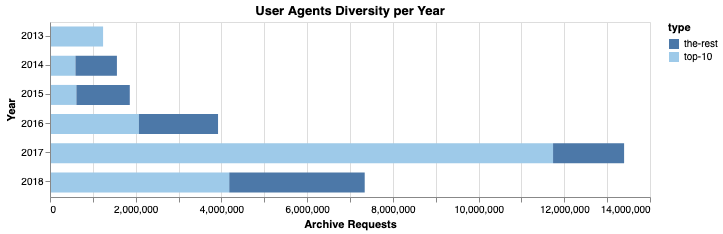

In [12]:
import altair
altair.renderers.enable('notebook')

chart = altair.Chart(ratios).mark_bar(size=20).encode(
    altair.X('sum(requests)', title='Archive Requests'),
    altair.Y('year', title='Year'),    
    altair.Color('bucket', title='type', scale=altair.Scale(scheme='tableau20'))
)
chart = chart.properties(
    width=600,
    height=175,
    title='User Agents Diversity per Year'
)
chart.interactive()

This is a helpful visualization because it shows that most of the time (except for year 1 when there is only one type of User-Agent) the top-10 User-Agents account for about 1/2 of the total requests. So there is definitely some diversity that's worth accounting for.

But 2017 is unusual in that by far the top-10 User-Agents account for the majority of the requests. Also there appears to have been almost double the amount of WARC request records that year, as compared to the year following. This is counter-intuitive because the amount of WARC data on disk does not follow that same trend. 

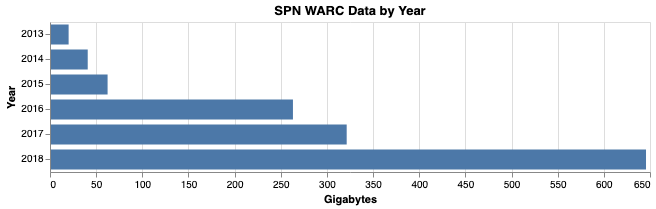

In [11]:
from os.path import getsize

"""
sizes = {'year': [], 'gb': []}
for year in range(2013, 2019):
    sizes['year'].append(str(year))
    warc_files = glob('warcs/liveweb-{}*/*.warc.gz'.format(year))
    sizes['gb'].append(sum([getsize(path) for path in warc_files]) / (1024 ** 3))
sizes = pandas.DataFrame(sizes)
"""
    
chart = altair.Chart(sizes).mark_bar(size=20).encode(
    altair.X('gb', title='Gigabytes'),
    altair.Y('year', title='Year')
)
chart = chart.properties(title='SPN WARC Data by Year', width=600, height=150)
chart.interactive()

# Lumping

As mentioned above there is some method in the madness of these strings. Fortunately the [ua-parser](https://www.uaparser.org/) project has collected a lot of data about web User-Agents, and buit a database of patterns that are used in parser toolkits for various languages. There is one for Python that we can use.

In [47]:
from ua_parser.user_agent_parser import Parse as parse_ua

parse_ua('Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.0 Safari/605.1.15')

{'user_agent': {'family': 'Safari',
  'major': '12',
  'minor': '0',
  'patch': None},
 'os': {'family': 'Mac OS X',
  'major': '10',
  'minor': '13',
  'patch': '6',
  'patch_minor': None},
 'device': {'family': 'Other', 'brand': None, 'model': None},
 'string': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.0 Safari/605.1.15'}

ua-parser breaks the User-Agent down into information about the user-agent, the operating system and the device.

In [84]:

from collections import defaultdict
data = defaultdict(int)
for row in df.items():
    if type(row[1]) != str:
        print(row)
    #if ua:
    #    parsed_ua = parse_ua(ua)
    #    if parsed_ua['user_agent']['family']:
    #        data[parsed_ua['user_agent']['family']] += 1

#print(data)
    

('2013', ua
Mozilla/5.0 (compatible; archive.org_bot; Wayback Machine Live Record; +http://archive.org/details/archive.org_bot)                                                                                                        1238598.0
Wget/1.19.5 (linux-gnu)                                                                                                                                                                                                          NaN
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36                                                                                                              NaN
Mozilla/5.0 (compatible; archive.org_bot; Wayback Machine Live Record; http://archive.org/details/archive.org_bot)                                                                                                               NaN
Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:62.0) Gecko/20100101 Firefo

In [44]:
parse_ua('curl/7.55.1')

{'user_agent': {'family': 'curl', 'major': '7', 'minor': '55', 'patch': '1'},
 'os': {'family': 'Other',
  'major': None,
  'minor': None,
  'patch': None,
  'patch_minor': None},
 'device': {'family': 'Other', 'brand': None, 'model': None},
 'string': 'curl/7.55.1'}

In trying to use the trace data in SavePageNow WARC data to understand the users of SavePageNow we've fallen down the rabbit hole of trying to understand the software.